In [1]:

import networkx as nx
import osmnx as ox
import time
import sys
import math
import numpy as np
from heapq import heappop, heappush
from itertools import count


In [2]:
G = ox.graph_from_place('Hungary', network_type='drive')

In [3]:
city_highways = ['living_street', 'primary', 'primary_link', 'residential',
                 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'unclassified']

In [4]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang
 

In [5]:
def bidirectional_dijstra(G, source, target, weight="weight"):
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if source == target:
        return (0, [source])

    weight = _weight_function(G, weight)
    push = heappush
    pop = heappop
    # Init:  [Forward, Backward]ű
    dists = [{}, {}]  # dictionary of final distances
    paths = [{source: [source]}, {target: [target]}]  # dictionary of paths
    fringe = [[], []]  # heap of (distance, node) for choosing node to expand
    seen = [{source: 0}, {target: 0}]  # dict of distances to seen nodes
    c = count()
    # initialize fringe heap
    push(fringe[0], (0, next(c), source))
    push(fringe[1], (0, next(c), target))
    # neighs for extracting correct neighbor information
    if G.is_directed():
        neighs = [G._succ, G._pred]
    else:
        neighs = [G._adj, G._adj]
    # variables to hold shortest discovered path
    # finaldist = 1e30000
    finalpath = []
    dir = 1
    while fringe[0] and fringe[1]:
        # choose direction
        # dir == 0 is forward direction and dir == 1 is back
        dir = 1 - dir
        # extract closest to expand
        (dist, _, v) = pop(fringe[dir])
        if v in dists[dir]:
            # Shortest path to v has already been found
            continue
        # update distance
        dists[dir][v] = dist  # equal to seen[dir][v]
        if v in dists[1 - dir]:
            # if we have scanned v in both directions we are done
            # we have now discovered the shortest path
            return (finaldist, finalpath)

        for w, d in neighs[dir][v].items():
            # weight(v, w, d) for forward and weight(w, v, d) for back direction
            if dir == 0:
                if v in paths[dir] and len(paths[dir][v]) > 1:
                    cost = weight(v, w, d, dir, paths[dir][v][-2])
                else:
                    cost = weight(v, w, d, dir)
            else:
                if w in paths[dir] and len(paths[dir][w]) > 1:
                    cost = weight(w, v, d, dir, paths[dir][w][-2])
                else:
                    cost = weight(w, v, d, dir)
                    
            if cost is None:
                continue
            vwLength = dists[dir][v] + cost
            if w in dists[dir]:
                if vwLength < dists[dir][w]:
                    raise ValueError("Contradictory paths found: negative weights?")
            elif w not in seen[dir] or vwLength < seen[dir][w]:
                # relaxing
                seen[dir][w] = vwLength
                push(fringe[dir], (vwLength, next(c), w))
                paths[dir][w] = paths[dir][v] + [w]
                if w in seen[0] and w in seen[1]:
                    # see if this path is better than the already
                    # discovered shortest path
                    totaldist = seen[0][w] + seen[1][w]
                    if finalpath == [] or finaldist > totaldist:
                        finaldist = totaldist
                        revpath = paths[1][w][:]
                        revpath.reverse()
                        finalpath = paths[0][w] + revpath[1:]
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")
    
def _weight_function(G, weight):
    
    if callable(weight):
        return weight
    # If the weight keyword argument is not callable, we assume it is a
    # string representing the edge attribute containing the weight of
    # the edge.
    if G.is_multigraph():
        return lambda u, v, d: min(attr.get(weight, 1) for attr in d.values())
    return lambda u, v, data: data.get(weight, 1)

In [6]:
def is_city(edge):
    if "highway" in edge and edge["highway"] in city_highways:
        return True
    return False

def is_left_turn(source, mid, target):
    source_node = G.nodes[source]
    mid_node = G.nodes[mid]
    target_node = G.nodes[target]
    
    return 225 < getAngle(
        (source_node['x'], source_node['y']),
        (mid_node['x'], mid_node['y']),
        (target_node['x'], target_node['y']),
        )

def crossroad_without_traffic_signal(node):
    return len(G._adj[node]) > 3 and ("highway" in G.nodes[node] and G.nodes[node]["highway"] != "traffic_signals")
    
    
def safest_weight(source, target, d, dir, prev_node=None):
    edge = d[0]    
    danger_rate = 1
    
    hour = int(time.strftime("%H"))
    
    if is_city(edge) and hour > 6 and hour < 20 or not is_city(edge) and (hour <= 6 or hour >= 20):
        danger_rate *= 2
    
    
    if prev_node != None:
        if dir == 0:
            if is_left_turn(prev_node, source, target):
                danger_rate *= 100
        else:
            if is_left_turn(target, source, prev_node):
                danger_rate *= 100
                
    if crossroad_without_traffic_signal(target):
        danger_rate *= 100
    
    
    return danger_rate * edge["length"]

In [7]:
def get_route(source_geo, dest_geo, weight='travel_time',plot=True):
    source_node, dist = ox.nearest_nodes(G, source_geo[0], source_geo[1], return_dist=True)
    target_node, dist = ox.nearest_nodes(G, dest_geo[0], dest_geo[1], return_dist=True)
    route = bidirectional_dijstra(G, source_node, target_node, weight=weight)
    
    if plot:
        ox.plot_graph_route(G, route[1], node_size=0, figsize=(40,40))
    return route

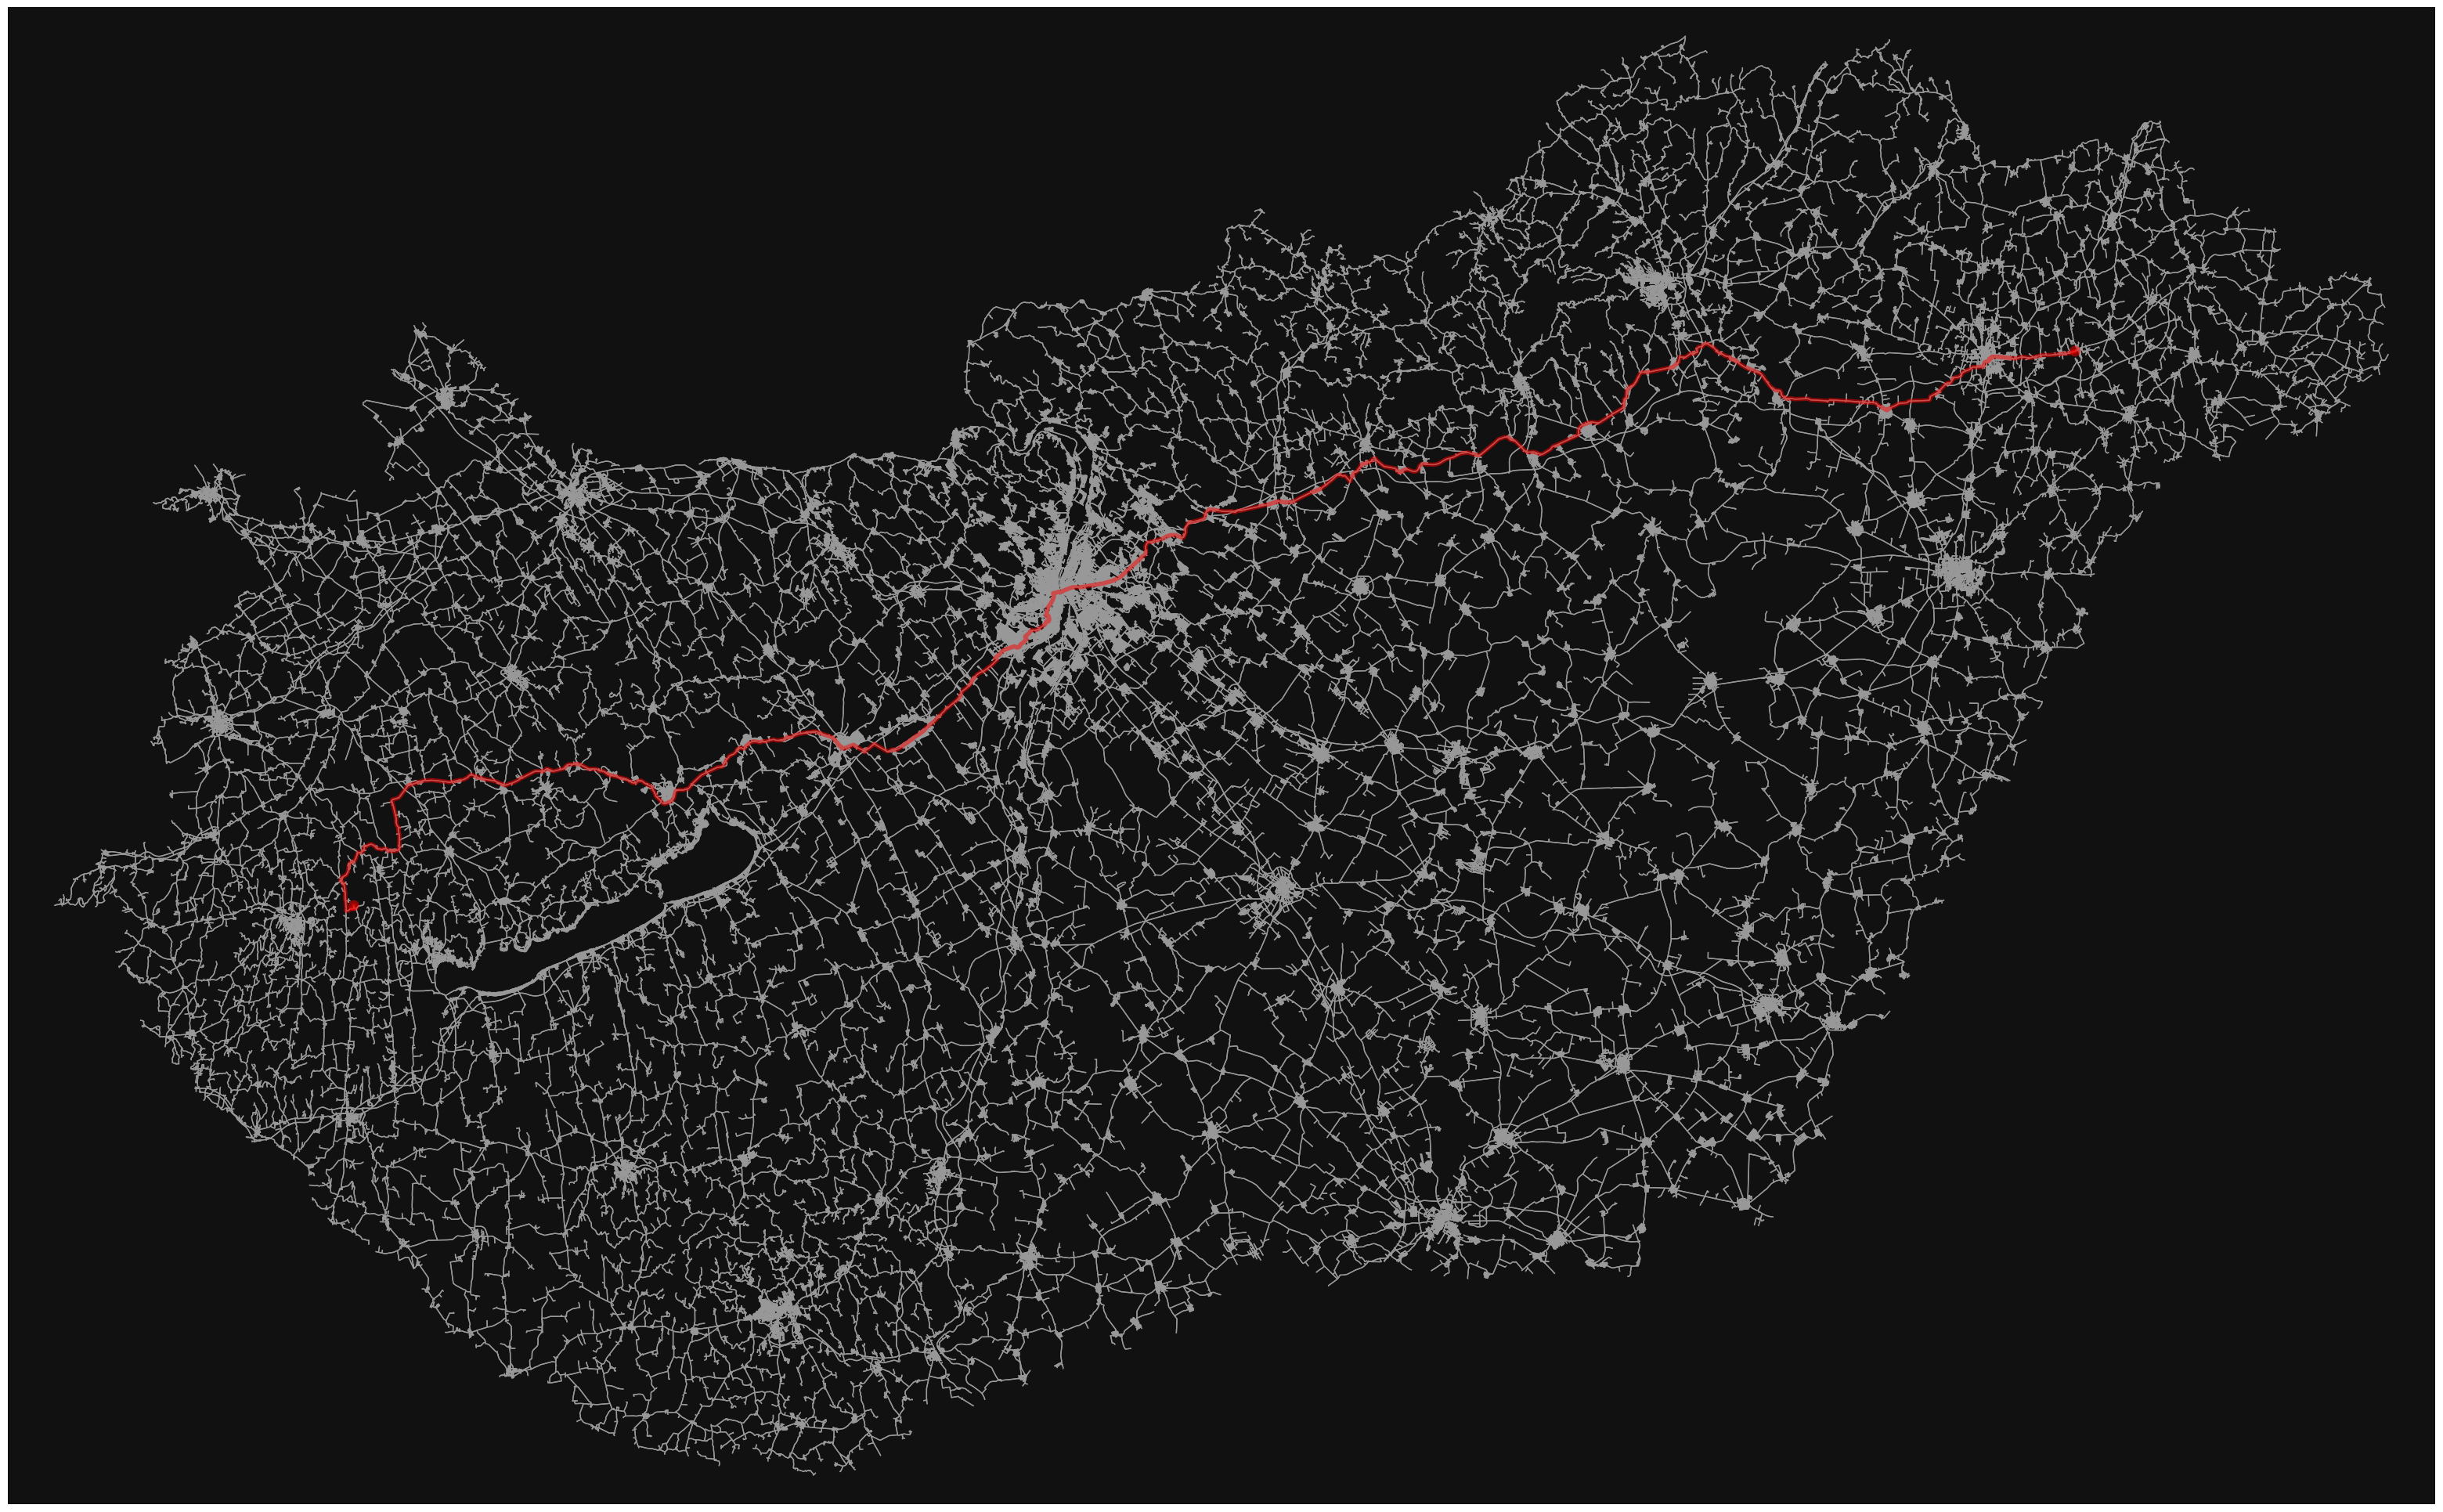

In [9]:
source_loc = (17.001899, 46.877254)
target_loc = (21.973212, 47.966179)
length, route = get_route(source_loc, target_loc, weight=safest_weight)